# Dataimport to SQLite

## Settings

In [1]:
classfile_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_11_02.csv'
subject_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

## Imports

In [2]:
import pandas as pd
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
### Functions from https://github.com/zooniverse/Data-digging/blob/master/example_scripts/astronomy_rewind/workflow1to2.py

def JSONParser(data):
    """call json.loads"""
    return json.loads(data)


def load_classifications(filename, json_columns=None):
    """
    Load classifications into pandas dataframe.
    Some columns of the csv are embedded json and need special parsing.
    """
    json_columns = json_columns or ['metadata', 'annotations', 'subject_data']
    converters = {i: JSONParser for i in json_columns}

    return pd.read_csv(filename, converters=converters)

def unpack(series):
    """
    Return the first value in a series.
    All annotations values are lists because of a few multiple tasks.
    The second multiple task always has the value of 'None of the above'
    (For this dataset!)
    """
    return [a[0] for a in series]


def parse_classifications(filename,**kwarg):
    """
    Load classifications and datamunge annotations column.
    """
    data = load_classifications(filename,**kwarg)

    # Only need the first item in the annotations list of json objects
    data['annotations'] = unpack(data['annotations'])
    return data

## Read data from csv to pandas dataframe
### classifications

In [4]:
classification_df = parse_classifications(classfile_in,json_columns=['metadata', 'annotations', 'subject_data']);
#Rename cloumn name to match with other tables
classification_df.rename(columns={'subject_ids': 'subject_id'}, inplace=True);classification_df.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_id
0,128465431,raspstephan,1814911.0,b454def8ef12f0860686,8072,Practice,19.13,2018-10-24 17:02:45 UTC,NaN,NaN,"{'source': 'api', 'session': '88559898111399b0...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976393': {'retired': None, 'fn': '/project...",26976393
1,128490303,not-logged-in-b454def8ef12f0860686,NaN,b454def8ef12f0860686,8072,Practice,24.13,2018-10-24 18:57:11 UTC,NaN,NaN,"{'source': 'api', 'session': '87cebe5a5f8df494...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977308': {'retired': None, 'fn': '/project...",26977308
2,128623366,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:49:06 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976669': {'retired': None, 'fn': '/project...",26976669
3,128623455,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:49:36 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976422': {'retired': None, 'fn': '/project...",26976422
4,128623533,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:50:08 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977225': {'retired': None, 'fn': '/project...",26977225


### subjects

In [5]:
subject_df = load_classifications(subject_in); subject_df.head()

,subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at
0,26976345,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
1,26976346,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:29 UTC,2018-10-24 16:42:29 UTC
2,26976347,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:31 UTC,2018-10-24 16:42:31 UTC
3,26976348,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:32 UTC,2018-10-24 16:42:32 UTC
4,26976349,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:33 UTC,2018-10-24 16:42:33 UTC


## Write dataframes to database

In [6]:
conn = sqlite3.connect("classifications.db")

In [7]:
# Unfortunately the dictionaries (annotations, metadata, etc. cannot be easily written to the table)
classification_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,13]].to_sql("classifications", conn, if_exists="replace")
subject_df.iloc[:,[0,1,2,3,6,7,8,9,10]].to_sql("subjects", conn, if_exists="replace")

## Read data from database

### First query example

In [8]:
user_name = 'ShCu'
workflow_id = 8072
user_DF = pd.read_sql_query("select * from classifications as c , subjects as s where c.user_name=='{}' and c.workflow_id=='{}';".format(user_name,workflow_id), conn)

In [9]:
user_DF.head()

,index,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,...,index,subject_id,project_id,workflow_id,subject_set_id,classifications_count,retired_at,retirement_reason,created_at,updated_at
0,2,128623366,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:49:06 UTC,None,...,0,26976345,7699,NaN,60713,0,None,None,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
1,3,128623455,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:49:36 UTC,None,...,0,26976345,7699,NaN,60713,0,None,None,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
2,4,128623533,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:50:08 UTC,None,...,0,26976345,7699,NaN,60713,0,None,None,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
3,5,128623611,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:50:39 UTC,None,...,0,26976345,7699,NaN,60713,0,None,None,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
4,6,128623713,ShCu,1830047.0,262955a3374c33958643,8072,Practice,24.13,2018-10-25 16:51:04 UTC,None,...,0,26976345,7699,NaN,60713,0,None,None,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC


### How often are the images of the *Practice* workflow classified?

In [10]:
workflow_id = 8072
workflow_version = 24.13
subject_set = 60902
practice_DF = pd.read_sql_query("select c.subject_id, c.user_id, c.workflow_version from classifications as c, subjects as s where c.workflow_id=='{}' AND c.workflow_version=='{}' AND s.subject_set_id='{}' AND s.subject_id==c.subject_id;".format(workflow_id, workflow_version, subject_set), conn)

In [11]:
import numpy as np
practice_data = np.empty((50,3))
info_str = 'index: {}, image_id: {}, image_seen: {} times from {} different users'
for i, (s, subject) in enumerate(practice_DF.groupby('subject_id')):
    practice_data[i,:]=[i, len(subject), len(np.unique(subject.user_id))]
    print(info_str.format(i, s, len(subject), len(np.unique(subject.user_id))))

index: 0, image_id: 27139637, image_seen: 35 times from 34 different users
index: 1, image_id: 27139657, image_seen: 38 times from 38 different users
index: 2, image_id: 27139658, image_seen: 40 times from 39 different users
index: 3, image_id: 27139668, image_seen: 38 times from 37 different users
index: 4, image_id: 27139670, image_seen: 40 times from 40 different users
index: 5, image_id: 27139724, image_seen: 43 times from 41 different users
index: 6, image_id: 27139807, image_seen: 44 times from 42 different users
index: 7, image_id: 27139823, image_seen: 42 times from 41 different users
index: 8, image_id: 27139855, image_seen: 41 times from 40 different users
index: 9, image_id: 27139862, image_seen: 45 times from 41 different users
index: 10, image_id: 27139902, image_seen: 41 times from 39 different users
index: 11, image_id: 27139914, image_seen: 52 times from 41 different users
index: 12, image_id: 27139915, image_seen: 38 times from 38 different users
index: 13, image_id: 2

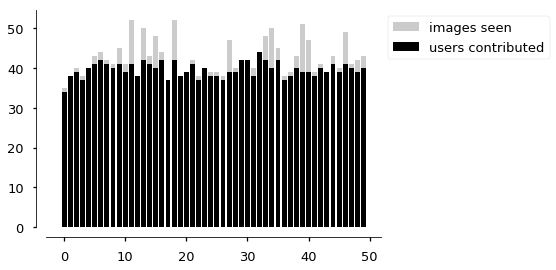

In [12]:
sns.set_context('talk')
plt.bar(practice_data[:,0], practice_data[:,1], color='k', alpha=0.2, label='images seen')
plt.bar(practice_data[:,0], practice_data[:,2], color='k', label='users contributed')
plt.legend(bbox_to_anchor=(1,1))
sns.despine(offset=10)

Due to the random selection (with placing back) of images during the classification process, users are shown the 'already seen' tag before they classified all 50 images. The analysis above shows, that this is the case after about 40 classifications.